## Setup

In [9]:
!python -m spacy download pt

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/Users/LeoWajnsztok/.pyenv/versions/ds/lib/python3.6/site-packages/pt_core_news_sm
-->
/Users/LeoWajnsztok/.pyenv/versions/ds/lib/python3.6/site-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [106]:
import pandas as pd
import numpy as np

In [107]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load dataset

In [108]:
initial_df = pd.read_csv('../data/entities_22-03-2018_ann.csv')

## Preprocess

In [109]:
# entity_df['phrase'] = entity_df['phrase'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
# entity_df['phrase'] = entity_df['phrase'].str.lower()
# entity_df.head()

initial_df['original'] = initial_df['original'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
initial_df['anottated'] = initial_df['anottated'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


In [110]:
import spacy
nlp = spacy.load('pt')

In [111]:
pos_tags = [
    'POS', 'PUNCT', 'SYM','ADJ',
    'NUM', 'DET', 'ADV', 'ADP',
    'X', 'VERB', 'CCONJ', 'NOUN',
    'PROPN', 'PART', 'INTJ', 'SPACE',
    'PRON', 'SCONJ', 'AUX', 'CONJ',
    'START', 'END',
]

labels_list = ['B-DEVICE','I-DEVICE','B-SCHEDULE', 'I-SCHEDULE','o']

In [112]:
from sklearn import preprocessing

pos_tags_hotencoder = preprocessing.LabelBinarizer()
pos_tags_hotencoder.fit(pos_tags)

labels_encoder = preprocessing.LabelEncoder()
labels_encoder.fit(labels_list)

LabelEncoder()

In [138]:
def has_digit(string):
    return int(bool(re.match(r'\d', string)))

def is_hour_format(string):
    return int(bool(re.match(r'^[0-9]{1,2}h([0-9]{2,2})?$', string)))

def is_de(string):
    return int(string in ['de', 'da', 'do'])

def generate_features(doc, pos):
    len_doc = len(doc)
    features = []
    token = doc[pos]
    features.append(has_digit(token.text))
    features.append(is_hour_format(token.text))
    features.append(is_de(token.text))
    for i in [-3,-2,-1, 0,1,2,3]:
        feat_pos = pos + i
        if feat_pos < 0:
            features.append('START')
        elif feat_pos >= len_doc:
            features.append('END')
        else:
            features.append(doc[feat_pos].pos_)
    return features

In [139]:
columns = ['f{}'.format(i) for i in range(10)]
columns.append('label')

features_df = pd.DataFrame(columns=columns)

In [140]:
import re

for index, row in initial_df.iterrows():
    doc = nlp(row['original'])
    labels = re.findall('\[@(.*?)\*\]', row['anottated'])
    labels_map = {k: v for k, v in [l.split('#') for l in labels]}  
    for token_index, token in enumerate(doc):
        new_row = generate_features(doc, token_index)
        label = labels_map.get(token.text, 'o')
        new_row.append(label)
        features_df = features_df.append(pd.DataFrame([new_row], columns=columns))
    

In [141]:
features_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,label
0,0,0,0,START,START,START,VERB,DET,NOUN,ADP,o
0,0,0,0,START,START,VERB,DET,NOUN,ADP,NOUN,o
0,0,0,0,START,VERB,DET,NOUN,ADP,NOUN,PUNCT,B-DEVICE
0,0,0,0,VERB,DET,NOUN,ADP,NOUN,PUNCT,END,o
0,0,0,0,DET,NOUN,ADP,NOUN,PUNCT,END,END,o


In [142]:
print (features_df.groupby('label').size())

features_unique_df = features_df.groupby(columns).size().reset_index(name='count')
features_unique_df = features_unique_df.drop('count', axis=1)

print (features_unique_df.groupby('label').size())

features_df['label_'] = labels_encoder.transform(features_df['label'])
features_unique_df['label_'] = labels_encoder.transform(features_unique_df['label'])

print (features_df.shape)
print (features_unique_df.shape)
print (features_unique_df.head())

label
B-DEVICE       260
B-SCHEDULE      70
I-DEVICE        84
I-SCHEDULE      42
o             1674
dtype: int64
label
B-DEVICE       139
B-SCHEDULE      62
I-DEVICE        42
I-SCHEDULE      41
o             1058
dtype: int64
(2130, 12)
(1342, 12)
   f0  f1  f2   f3   f4     f5    f6    f7     f8   f9       label  label_
0   0   0   0  ADJ  ADJ    ADP  NOUN   END    END  END  I-SCHEDULE       3
1   0   0   0  ADJ  ADJ  CCONJ   ADJ   END    END  END           o       4
2   0   0   0  ADJ  ADJ   NOUN   DET   NUM  CCONJ    X           o       4
3   0   0   0  ADJ  ADP   NOUN   ADJ   END    END  END  I-SCHEDULE       3
4   0   0   0  ADJ  ADP   NOUN   ADP  NOUN    END  END           o       4


In [143]:
# feat_encoded = features_unique_df.copy()
# feat_encoded = features_df.copy()

# has features for all available categories
# for c in feat_encoded.columns[:-2]:
#   feat_encoded = feat_encoded.join(pd.DataFrame(pos_tags_hotencoder.transform(feat_encoded.pop(c)), columns=[c + '_' + clss for clss in pos_tags_hotencoder.classes_]))
  
# print (len(feat_encoded.columns))
# feat_encoded.head()


# only has features for existing categories on dataset
feat_encoded = pd.get_dummies(features_df, columns=features_df.columns[3:-2])
feat_encoded.head(1)

,f0,f1,f2,label,label_,f3_ADJ,f3_ADP,f3_ADV,f3_AUX,f3_CCONJ,...,f9_END,f9_NOUN,f9_NUM,f9_PRON,f9_PROPN,f9_PUNCT,f9_SCONJ,f9_SYM,f9_VERB,f9_X
0,0,0,0,o,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
features_columns = list(set(feat_encoded.columns) - {'label', 'label_'})

print (features_columns)

['f3_PROPN', 'f6_NUM', 'f5_ADV', 'f5_NUM', 'f3_ADP', 'f9_SYM', 'f5_PUNCT', 'f3_VERB', 'f4_START', 'f4_PRON', 'f6_CCONJ', 'f9_SCONJ', 'f9_ADP', 'f8_PROPN', 'f6_PUNCT', 'f7_END', 'f8_END', 'f6_DET', 'f3_SCONJ', 'f7_ADV', 'f7_DET', 'f8_ADJ', 'f3_ADJ', 'f8_VERB', 'f6_VERB', 'f9_CCONJ', 'f3_CCONJ', 'f8_AUX', 'f6_PRON', 'f7_PRON', 'f5_VERB', 'f8_X', 'f9_VERB', 'f4_NOUN', 'f4_PUNCT', 'f6_SCONJ', 'f3_DET', 'f9_NUM', 'f8_DET', 'f4_ADJ', 'f5_PROPN', 'f6_ADJ', 'f9_END', 'f5_ADJ', 'f4_SYM', 'f3_ADV', 'f5_AUX', 'f8_PUNCT', 'f7_AUX', 'f6_SYM', 'f7_NOUN', 'f8_ADV', 'f8_NOUN', 'f5_SCONJ', 'f9_PROPN', 'f2', 'f4_ADV', 'f7_NUM', 'f9_PUNCT', 'f6_NOUN', 'f7_ADJ', 'f4_ADP', 'f4_VERB', 'f5_DET', 'f6_AUX', 'f9_NOUN', 'f5_SYM', 'f9_PRON', 'f8_NUM', 'f7_SCONJ', 'f0', 'f6_ADP', 'f9_ADJ', 'f6_PROPN', 'f4_SCONJ', 'f4_PROPN', 'f7_PUNCT', 'f8_PRON', 'f4_CCONJ', 'f3_NOUN', 'f6_X', 'f5_PRON', 'f5_ADP', 'f3_START', 'f7_PROPN', 'f3_PUNCT', 'f3_AUX', 'f9_DET', 'f1', 'f7_CCONJ', 'f8_ADP', 'f5_CCONJ', 'f8_SCONJ', 'f3_NUM',

In [145]:
len(features_columns)

110

In [146]:
from sklearn.model_selection import train_test_split

trainData, testData, trainLabels, testLabels = train_test_split(feat_encoded[features_columns], feat_encoded['label_'], test_size=0.2, random_state=42)
testLabels = testLabels.astype(int)
trainLabels = trainLabels.astype(int)
len(trainData), len(testData), len(trainLabels), len(testLabels)

(1704, 426, 1704, 426)

In [147]:
len(trainData.columns), len(testData.columns)

(110, 110)

## Classifier

In [122]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

models = [
    ('GradientBoostingClassifier', GradientBoostingClassifier(), {}),
    ('LinearSVC', LinearSVC(), {}),
    ('SGD', SGDClassifier(), {}),
]

In [123]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import strip_accents_ascii
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV 


results = []
names = []
best_model = None
max_score = -1

for name, model, cls_params in models:
    pipe = Pipeline([('clf', model)])
  
    gs_cls = GridSearchCV(pipe, cls_params, n_jobs=1)
    gs_cls = gs_cls.fit(trainData, trainLabels)
  
    print ("Model: "+ name)
    print ("Best cross-validation score: " + str(gs_cls.best_score_))
    print ("Best parameters: " + str(gs_cls.best_params_))

    predictions = gs_cls.predict(testData)
    score = gs_cls.score(testData, testLabels)
    print ("Accuracy: " + str(score))

    if score > max_score:
        max_score = score
        best_model = gs_cls

    cm = confusion_matrix(testLabels, predictions)
    for i, l in enumerate(cm):
        print ('{0: <10} {1}'.format(labels_list[i], ''.join(['{0: <3}'.format(x) for x in l])))
    
    print (classification_report(testLabels, predictions))
  
#   result_df = pd.DataFrame(list(zip(testData,testLabels)))
#   result_df['pred'] = predictions
#   result_df[result_df[1] != result_df['pred']]
                       
    names.append(name)
    results.append(score)

Model: GradientBoostingClassifier
Best cross-validation score: 0.9061032863849765
Best parameters: {}
Accuracy: 0.9342723004694836
B-DEVICE   46 0  1  0  5  
I-DEVICE   0  7  0  0  0  
B-SCHEDULE 0  0  10 0  3  
I-SCHEDULE 0  2  0  3  1  
o          8  6  1  1  332
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        52
           1       0.47      1.00      0.64         7
           2       0.83      0.77      0.80        13
           3       0.75      0.50      0.60         6
           4       0.97      0.95      0.96       348

    accuracy                           0.93       426
   macro avg       0.78      0.82      0.77       426
weighted avg       0.94      0.93      0.94       426

Model: LinearSVC
Best cross-validation score: 0.9061032863849765
Best parameters: {}
Accuracy: 0.9366197183098591
B-DEVICE   48 0  1  0  3  
I-DEVICE   0  6  0  0  1  
B-SCHEDULE 0  0  10 0  3  
I-SCHEDULE 0  2  0  1  3  
o          7  3  1  3  

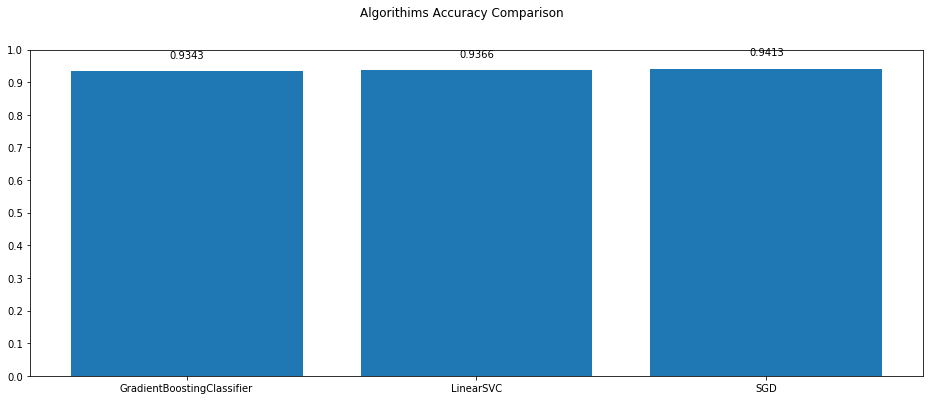

In [124]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,1, figsize=(16, 6))
fig.suptitle('Algorithims Accuracy Comparison')
plt.bar(names, results, )
plt.ylim(0,1)
plt.yticks(np.arange(0,1.1,0.1))
for i, v in enumerate(names):
    ax.text(v, results[i] + 0.05, '%.4f' %(results[i]), ha='center', va='center')

    
plt.show()

## Save model

In [125]:
import pickle

filename = '../models/entities_model.sav' 
with open(filename, 'wb') as f:
    pickle.dump(best_model, f, protocol=2)

## Predict

In [148]:
# feat_encoded = features_unique_df.copy()
# feat_encoded = features_df.copy()

# has features for all available categories
# for c in feat_encoded.columns[:-2]:
#   feat_encoded = feat_encoded.join(pd.DataFrame(pos_tags_hotencoder.transform(feat_encoded.pop(c)), columns=[c + '_' + clss for clss in pos_tags_hotencoder.classes_]))
  
# print (len(feat_encoded.columns))
# feat_encoded.head()


# only has features for existing categories on dataset
# feat_encoded = pd.get_dummies(features_df, columns=features_df.columns[:-2])
# print (feat_encoded.head(2))
# features_columns = feat_encoded.columns[2:]

In [206]:
def process(sent):
    d = pd.DataFrame(columns=columns[:-1])
    doc = nlp(sent)
    for i, token in enumerate(doc):
        new_row = generate_features(doc, i)
        d = d.append(pd.DataFrame([new_row], columns=columns[:-1]))
    d = pd.get_dummies(d)
    
    # Get missing columns in the training test
    missing_cols = set( features_columns ) - set( d.columns )
    
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        d[c] = 0
        
    # Ensure the order of column in the test set is in the same order than in train set
    return d[features_columns]

def predict(sent):
    d = process(sent)
    p = best_model.predict(d)
    return labels_encoder.inverse_transform(p)


In [221]:
for s in initial_df['original'][:10]:
    print (s, predict(s))

Liga a televisao por favor. ['o' 'o' 'B-DEVICE' 'o' 'o' 'o']
Ligue o ar condicionado. ['o' 'o' 'B-DEVICE' 'I-DEVICE' 'o']
Ar condicionado ligado. ['B-DEVICE' 'I-DEVICE' 'o' 'o']
Liga a luz do quarto ai. ['o' 'o' 'B-DEVICE' 'o' 'o' 'o' 'o']
Liga meu computador pra mim. ['o' 'o' 'B-DEVICE' 'o' 'o' 'o']
Acende a luz da cozinha por favor. ['o' 'o' 'B-DEVICE' 'o' 'o' 'o' 'o' 'o']
Liga o som. ['o' 'o' 'B-DEVICE' 'o']
Bota um som ai pra mim. ['o' 'o' 'B-DEVICE' 'o' 'o' 'o' 'o']
Bota uma musica ai. ['o' 'o' 'B-DEVICE' 'o' 'o']
Meu quarto esta um pouco escuro. ['o' 'o' 'o' 'o' 'o' 'o' 'o']


In [222]:
predict('Liga o ar condicionado todo dia a noite')

array(['o', 'o', 'B-DEVICE', 'o', 'o', 'B-DEVICE', 'o', 'o'], dtype='<U10')

In [223]:
predict('liga o ar condicionado')

array(['o', 'o', 'B-DEVICE', 'I-DEVICE'], dtype='<U10')

In [224]:
predict('acende a luz do meu quarto')

array(['o', 'o', 'B-DEVICE', 'o', 'o', 'o'], dtype='<U10')

In [225]:
predict('liga todas as luzes das salas de reunião')

array(['o', 'o', 'o', 'B-DEVICE', 'o', 'B-DEVICE', 'o', 'B-DEVICE'],
      dtype='<U10')

In [226]:
predict('liga a televisao do 5 andar')

array(['o', 'o', 'o', 'o', 'o', 'o'], dtype='<U10')

## CRF

In [227]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [ ]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]